Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, roc_curve, auc, roc_auc_score
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [2]:
data = pd.read_csv("C:/Users/Godwin/Documents/Workflow/ML Zoomcamp/Classification/Customer-churn/Telco-Customer-Churn.csv")
data.columns = data.columns.str.replace(' ', '_').str.lower()

categorical_col = data.dtypes[data.dtypes == 'object'].index.tolist()

for col in categorical_col:
    data[col] = data[col].str.replace(' ', '_').str.lower()
#data.head()

EDA

In [3]:
#Checking Data infomation
#data.info()

In [4]:
#Checking for null values
#data.isnull().sum()

In [5]:
#data.head()

In [6]:
#Changing totalcharges column to float
#data['totalcharges'] = data['totalcharges'].astype('float')

In [7]:
data['totalcharges'] = pd.to_numeric(data['totalcharges'], errors= 'coerce')

In [8]:
#data.info()

In [9]:
#Checking number of unique values in each column
#data.nunique()

In [10]:
#data.isnull().sum()

In [11]:
#Filling null values
data['totalcharges'].fillna(data['totalcharges'].mean(), inplace = True)

In [12]:
#Visualization 

def displayBarValues(chartName,ty=""):
    for p in chartName.patches:
        bar_height = p.get_height() if not pd.isnull(p.get_height()) else 0
        bar_width = p.get_width() if not pd.isnull(p.get_width()) else 0
        bar_x = p.get_x() if not pd.isnull(p.get_x()) else 0
        if(ty=="per"):
            chartName.text(bar_x + (bar_width / 2.5),
                bar_height +0.9,(str)(round(bar_height,1))+"%" or '', color='black', ha="center")
        else:
            chartName.text(bar_x + (bar_width / 2.0),
                bar_height +0.9,(round(bar_height,1)) or '', color='black', ha="center")

In [13]:
categorical_col = data.dtypes[data.dtypes == 'object'].index.tolist()
numerical_col = ['tenure', 'totalcharges', 'monthlycharges']

categorical_col.remove('customerid')
# plt.figure(figsize = (15,25))
# rows = int(len(categorical_col)/4 +1)
# for i,col in enumerate(categorical_col):

#     plt.subplot(rows, 4, i+1)
#     chart = sns.countplot(x = col, data = data, order = data[col].value_counts(normalize=True).sort_values().index)
#     displayBarValues(chart)
#     plt.xticks(rotation = 90)

In [14]:
#Percentage of churning to not churning
#(data['churn'].value_counts(normalize=True)*100).sort_values()

In [15]:
#Covert churn column to integer
data['churn'] = (data.churn=='yes').astype(int)


# #Checking churning rate in relation to other columns
# global_churn_rate = data['churn'].mean()
# print('The churning rate of the company is ',global_churn_rate)

# female_churn = data[data['gender'] == 'female']['churn'].mean()
# print('The churning rate of females in the company is ', female_churn)
# male_churn = data[data['gender'] == 'male']['churn'].mean()
# print('The churning rate of males in the company is ',male_churn)

Relationship between columns and the churning rate

In [16]:
# for i in categorical_col:
#     data_group = data.groupby(i)['churn'].agg(['mean'])
#     data_group['difference'] = data_group['mean'] - global_churn_rate
#     data_group['risk'] = data_group['mean']/ global_churn_rate
#     display(data_group)
#     print()
#     print()

In [17]:
#Relationship between numerical columns and the target variable
data[numerical_col].corrwith(data['churn'])

tenure           -0.352229
totalcharges     -0.199428
monthlycharges    0.193356
dtype: float64

In [18]:
#Binnning columns to extract information

data['tenure_bins'] = pd.cut(x = data['tenure'], bins = [0, 30, 60, 90], labels = ['0 - 30', '31 - 60', '61 - 90'])

data['monthly_bins'] = pd.cut(x = data['monthlycharges'], bins = [0, 50, 100, 150], labels = ['0 - 50', '51 - 100', '101 - 150'])

In [19]:
#data.groupby(['tenure_bins'])['churn'].agg('mean')

In [20]:
# chart = sns.countplot(x = 'tenure_bins', data = data, order = data['tenure_bins'].value_counts(normalize=True).sort_values().index)
# displayBarValues(chart)
# plt.xticks(rotation = 90)

In [21]:
#data.groupby(['monthly_bins'])['churn'].agg('mean')

In [22]:
# chart = sns.countplot(x = 'monthly_bins', data = data, order = data['monthly_bins'].value_counts(normalize=True).sort_values().index)
# displayBarValues(chart)
# plt.xticks(rotation = 90)

In [23]:
#data.drop(['tenure_bins', 'monthly_bins'], axis = 1, inplace = True)

In [24]:
# #Function for mutual information between features and target
# def mutual_info(series):
#     return mutual_info_score(series, data['churn'])

# mi = data[categorical_col].apply(mutual_info)
# mi.sort_values(ascending = False)

In [25]:
#Spliting the data
train_df, test_df = train_test_split(data, test_size = 0.2, random_state=1)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state=1)

y_train = train_df.pop('churn')
y_test = test_df.pop('churn')
y_val = val_df.pop('churn')

In [26]:
#Encoding the data with DictVectorizer
dv = DictVectorizer(sparse = False)

categorical_col.remove('churn')
dv.fit(train_df[categorical_col + numerical_col].to_dict(orient = 'records'))
X_train = dv.transform(train_df[categorical_col + numerical_col].to_dict(orient = 'records'))
X_test =  dv.transform(test_df[categorical_col + numerical_col].to_dict(orient = 'records'))
X_val =  dv.transform(val_df[categorical_col + numerical_col].to_dict(orient = 'records'))

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)

weights = model.coef_[0].round(3)
bias = model.intercept_.round(3)

In [28]:
#Model validation
prediction = model.predict_proba(X_val)[:,1]
churn_decision = (prediction >= 0.5)

print((y_val == churn_decision).mean())
churn_decision = churn_decision.astype('int')

0.7991483321504613


Training on full data

In [29]:
#full_df = pd.concat([train_df, val_df])
#label = pd.concat([y_train, y_val])

In [30]:
#full = full_df[categorical_col + numerical_col].to_dict(orient = 'record')
#new_df = dv.fit_transform(full)
#model.fit(new_df, label)

Making Prediction

In [31]:
prediction = model.predict_proba(X_val)[:, 1]
#prediction = (prediction >= 0.5)
#prediction = prediction.astype('int')
#print('The accuracy of the model is ', (y_val == prediction).mean())
#dictionary = {'Customerid': test_df['customerid'], "Actual": y_test, 'Predicted': prediction, "Match": y_test == prediction}
#output = pd.DataFrame(dictionary)

In [32]:
#output.head(20)

In [33]:
#output[output['Match'] == False]['Customerid'].shape

In [34]:
def metric(actual, predicted, t):

    accuracy = (predicted == actual).mean()
    actual_positive = (actual == 1)
    actual_negative = (actual == 0)

    predicted_positive = (predicted >= t)
    predicted_negative = (predicted < t)



    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    tpr = tp/ (tp + fn)
    fpr = fp/ (fp + tn)

    precision = tp/(tp + fp)
    recall = tp/(tp +fn)
    f1_score = 2 * ((precision * recall)/ (precision + recall))

    return tn, fp, fn, tp, precision, recall, tpr, fpr, f1_score

In [35]:
tn, fp, fn, tp, precision, recall, tpr, fpr, f1_score = metric(y_val, prediction, 0.5)
cm = np.array([[tn, fp], [fn, tp]])

threshold = np.linspace(0, 1, 101)

score = []
for t in threshold:
    tn, fp, fn, tp, precision, recall, tpr, fpr, f1_score = metric(y_val, prediction, t)
    score.append((t, tn,fp,fn,tp, tpr, fpr))

df = pd.DataFrame(score, columns= ['threshold','true_negative', 'false_positive', 'false_negative', 'true_positive', 'true_positive_rate', 'false_positive_rate'])
df[::10]

,threshold,true_negative,false_positive,false_negative,true_positive,true_positive_rate,false_positive_rate
0,0.0,0,1023,0,386,1.000000,1.000000
10,0.1,475,548,20,366,0.948187,0.535679
20,0.2,665,358,53,333,0.862694,0.349951
30,0.3,784,239,98,288,0.746114,0.233627
40,0.4,849,174,136,250,0.647668,0.170088
50,0.5,915,108,175,211,0.546632,0.105572
60,0.6,969,54,230,156,0.404145,0.052786
70,0.7,1004,19,309,77,0.199482,0.018573
80,0.8,1022,1,378,8,0.020725,0.000978
90,0.9,1023,0,386,0,0.000000,0.000000


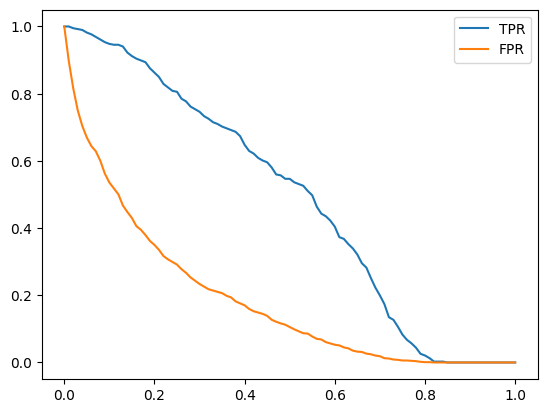

In [36]:
plt.plot(df.threshold, df.true_positive_rate, label = 'TPR')
plt.plot(df.threshold, df.false_positive_rate, label = 'FPR')
plt.legend()

In [37]:
y_rand = np.random.uniform(0,1, size=len(y_val))
((y_rand >= 0.5) == y_val).mean()

0.4804826117814053

In [38]:
def model_rates(y_test, prediction):
        
    threshold = np.linspace(0, 1, 101)

    score = []
    for t in threshold:

        actual_positive = (y_test == 1)
        actual_negative = (y_test == 0)

        predicted_positive = (prediction >= t)
        predicted_negative = (prediction < t)

        true_positive = (actual_positive & predicted_positive).sum()
        true_negative = (actual_negative & predicted_negative).sum()
        false_positive = (actual_negative & predicted_positive).sum()
        false_negative = (actual_positive & predicted_negative).sum()

        score.append((t,true_positive, false_positive, false_negative, true_negative))

    df = pd.DataFrame(score, columns= ['threshold','true_positive', 'false_positive', 'false_negative', 'true_negative'])
    df.true_positive_rate = df.true_positive/(df.true_positive + df.false_negative)
    df.false_positive_rate = df.false_positive/(df.true_negative + df.false_positive)

    return df

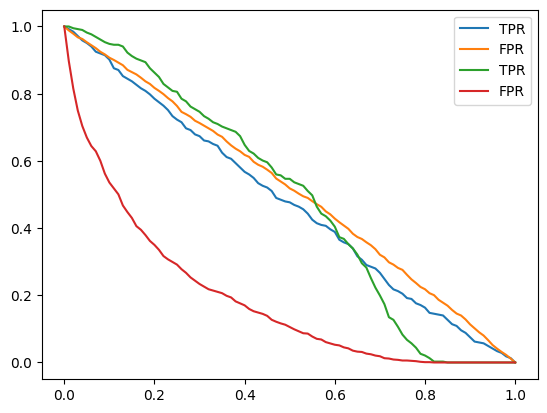

In [39]:
rand_df = model_rates(y_val, y_rand)

plt.plot(rand_df.threshold, rand_df.true_positive_rate, label = 'TPR')
plt.plot(rand_df.threshold, rand_df.false_positive_rate, label = 'FPR')

plt.plot(df.threshold, df.true_positive_rate, label = 'TPR')
plt.plot(df.threshold, df.false_positive_rate, label = 'FPR')
plt.legend()

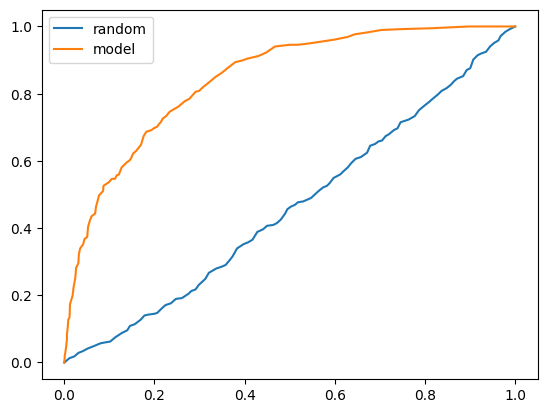

In [40]:
plt.plot(rand_df.false_positive_rate, rand_df.true_positive_rate, label = 'random')

plt.plot(df.false_positive_rate, df.true_positive_rate, label = 'model')
plt.legend()

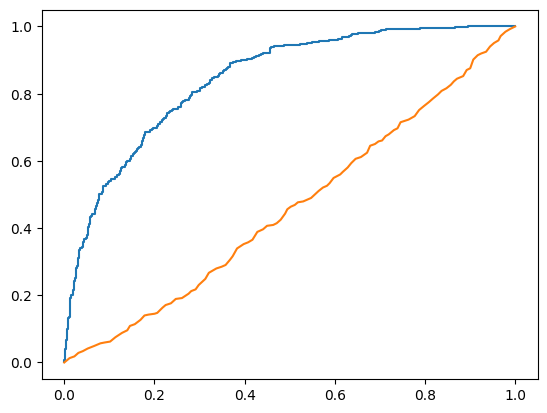

In [41]:
fpr, tpr, thres = roc_curve(y_val, prediction)
plt.plot(fpr, tpr)
plt.plot(rand_df.false_positive_rate, rand_df.true_positive_rate, label = 'random')

In [42]:
auc(fpr, tpr)

0.8435339522586722

In [43]:
roc_auc_score(y_val, prediction)

0.8435339522586722

In [44]:
def train(data, y, c):
    dv.fit(data[categorical_col + numerical_col].to_dict(orient = 'records'))
    X_train = dv.transform(data[categorical_col + numerical_col].to_dict(orient = 'records'))

    model = LogisticRegression(C = c, max_iter = 1000)
    model.fit(X_train, y)
    return dv, model

def predict(data, dv, model):
    X_test = dv.transform(data[categorical_col + numerical_col].to_dict(orient = 'records'))
    prediction = model.predict_proba(X_test)[:,1]
    return prediction

In [45]:
full_df = pd.concat([train_df,val_df])
full_df['label'] = (pd.concat([y_train,y_val]))

kfold = KFold(n_splits=10, shuffle= True, random_state=1)
train_idx, val_idx = next(kfold.split(full_df))

In [46]:
reg = [0.0001,0.01,0.1,1,10,100]

for i in tqdm(reg):

    scores = []
    for train_idx, val_idx in kfold.split(full_df):

        train_df = full_df.iloc[train_idx]
        val_df = full_df.iloc[val_idx]

        y_train = train_df.pop('label')
        y_val = val_df.pop('label')

        dv, model = train(train_df, y_train, i)
        prediction = predict(val_df, dv, model)

        auc = roc_auc_score(y_val, prediction)
        scores.append(round(auc, 3))

    print(f'C {i}, Auc_score {np.mean(scores)}, STD {np.std(scores)}')

  0%|          | 0/6 [00:00<?, ?it/s]

C 0.0001, Auc_score 0.8108000000000001, STD 0.00898665677546435
C 0.01, Auc_score 0.8398, STD 0.01331014650557988
C 0.1, Auc_score 0.841, STD 0.015504837954651459
C 1, Auc_score 0.8412, STD 0.015529327094243343
C 10, Auc_score 0.8402, STD 0.014337363774418238
C 100, Auc_score 0.841, STD 0.015773395322504297


In [47]:
full_df = (pd.concat([train_df,val_df]))
label = (pd.concat([y_train,y_val]))

dv, model = train(full_df, label, 1)
prediction = predict(test_df, dv, model)
auc = roc_auc_score(y_test, prediction)

In [50]:
auc

0.858183832212075

In [48]:
# nums = [1,2,3,3,4,5,6,12,3,2,4,4]

# def factor(num):
#     nums_len = len(nums)
#     prev_pos, curr_pos = 0, 0
#     for index in range(1, nums_len):
        
#         if nums[index] != nums[prev_pos]:
#             curr_pos += 1
#             nums[curr_pos] = nums[index]
        
#         prev_pos += 1
        
#     return curr_pos + 1

# factor(nums)



#DAY 2
# nums = [3,2,2,3]
# val = 3
# current= 0

# nums_len = len(nums)
# for i in range(nums_len):
#     if nums[i] != val:
#         nums[current], nums[i] = nums[i], nums[current]
#         current +=1
# del nums[current:]

# nums_len = len(nums)
#         out = []
#         for i in nums:
#             if i != val:
#                 out.append(i)
                
#         for i in range(len(out)):
#             nums[i] = out[i]




#DAY 3

# def reverse_number(x):
#     if x < 0:
#         return False

#     reversed_number = 0
#     number = x
#     while number != 0:
#         digit = number % 10
#         reversed_number = reversed_number * 10 + digit
#         number //= 10

#     if reversed_number == x:
#         return True

In [49]:
s = 'tree'

number = {}
for i in s:
    if i not in number.keys():
        number[i] = s.count(i)

out = ''

for i in range(2):
    max_val = max(number.values())
    for u in number:
        if number[u] == max_val:
            out = out + (u*max_val)
            number.pop(u)

RuntimeError: dictionary changed size during iteration

In [ ]:
print(out)

eetr
